Papers:
- 

Preprocessing:
- [DONE] remove zones with no data
- [DONE] detect and handle missing values (imputation methods: ffill)
- [DONE] create features -> features.ipynb
- [DONE] Remove last (longest_allowed_gap - 1) values after imputation
- [TODO] Impute "ASBENT" value instead of "nan"
- [TODO] detect and handle outliers
- [TODO] normalize/standardize

Algorithms to try:
- [TODO] Linear model
- [OPEN] Random forests
- [TODO] SVM
- [TODO] RNN

Present results:
- [DONE] Present training results for all patients in one plot


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11, 4)})

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from statistics import mean, stdev

# Decision trees
from sklearn.tree import DecisionTreeClassifier
# Random Forests"
from sklearn.ensemble import RandomForestClassifier
# Grid search
from sklearn.model_selection import GridSearchCV



## Load data

In [2]:
samples = pd.read_csv("data/raw/dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [3]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [4]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [5]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [6]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make features
More feature ideas: 
- weekday vs. weekend day
- day of the week
- recent values from patient-reported data
- relevant app usage data
- use weighted window for aggregated features from the past days
- did patient enter data (mood/valence/arousal) today

To do feature engineering:
- missing mood values: either
   - remove timespans with no mood data: keep only the longest continuous timespan with mood data
   - only remove outside timespans with no mood data, and *backfill* (NOT *interpolate*) inside (seems reasonable for most patient, except maybe the last two)

To do data cleaning:
- discard outliers

To do train:
- retrain on whole train partition after CV

In [7]:
ids = list(samples["id"].unique())
positive_mood_threshold = 7
longest_allowed_gap = 3

d = {}
for id in ids:
    d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "mood_1D_ffilled")] = vdata.loc[:, (id , 'mood')].resample('D').mean().fillna(method='ffill', limit=longest_allowed_gap)
    d[(id, "valence_1D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean().fillna(method='ffill')
    d[(id, "arousal_1D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean().fillna(method='ffill')
    d[(id, "social_1D")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "social_rolling_5D")] = vdata.loc[:, (id , 'appCat.social')].rolling('5D').sum().resample('D').mean() / 5
    d[(id, "social_rolling_10D")] = vdata.loc[:, (id , 'appCat.social')].rolling('10D').sum().resample('D').mean() / 10
    
    mood = vdata.loc[:, (id, 'mood')]
    mood.dropna(inplace=True)
    d[(id, 'mood_first')] = mood.resample('D').first()
    d[(id, 'mood_last')] = mood.resample('D').last()
    d[(id, 'mood_delta')] = d[(id, 'mood_last')] - d[(id, 'mood_first')]
    
    d[(id, "target")] = d[(id, "mood_1D_ffilled")].shift(-1)
    # converting to int just so we can plot it
    d[(id, "target_binary")] = (d[(id, "target")] >= positive_mood_threshold).astype(int)
    
features = pd.DataFrame(d)
features

AS14.01                                                  \
           mood_1D mood_1D_ffilled valence_1D arousal_1D social_1D   
datetime                                                             
2014-02-17     NaN             NaN        NaN        NaN       0.0   
2014-02-18     NaN             NaN        NaN        NaN       0.0   
2014-02-19     NaN             NaN        NaN        NaN       0.0   
2014-02-20     NaN             NaN        NaN        NaN       0.0   
2014-02-21     NaN             NaN        NaN        NaN       0.0   
...            ...             ...        ...        ...       ...   
2014-06-05     NaN             NaN        1.0       -0.5       0.0   
2014-06-06     NaN             NaN        1.0       -0.5       0.0   
2014-06-07     NaN             NaN        1.0       -0.5       0.0   
2014-06-08     NaN             NaN        1.0       -0.5       0.0   
2014-06-09     NaN             NaN        1.0       -0.5       0.0   

                                                                      \
           social_rolling_5D social_rolling_10D mood_first mood_last   
datetime                                                               
2014-02-17               NaN                NaN        NaN       NaN   
2014-02-18               NaN                NaN        NaN       NaN   
2014-02-19               NaN                NaN        NaN       NaN   
2014-02-20               NaN                NaN        NaN       NaN   
2014-02-21               NaN                NaN        NaN       NaN   
...                      ...                ...        ...       ...   
2014-06-05               NaN                NaN        NaN       NaN   
2014-06-06               NaN                NaN        NaN       NaN   
2014-06-07               NaN                NaN        NaN       NaN   
2014-06-08               NaN                NaN        NaN       NaN   
2014-06-09               NaN                NaN        NaN       NaN   

                       ...    AS14.33                                         \
           mood_delta  ... valence_1D arousal_1D social_1D social_rolling_5D   
datetime               ...                                                     
2014-02-17        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-18        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-19        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-20        NaN  ...        NaN        NaN       0.0               NaN   
2014-02-21        NaN  ...        NaN        NaN       0.0               NaN   
...               ...  ...        ...        ...       ...               ...   
2014-06-05        NaN  ...        1.0       -2.0       0.0               NaN   
2014-06-06        NaN  ...        1.0       -2.0       0.0               NaN   
2014-06-07        NaN  ...        1.0       -2.0       0.0               NaN   
2014-06-08        NaN  ...        1.0       -2.0       0.0               NaN   
2014-06-09        NaN  ...        1.0       -2.0       0.0               NaN   

                                                                      \
           social_rolling_10D mood_first mood_last mood_delta target   
datetime                                                               
2014-02-17                NaN        NaN       NaN        NaN    NaN   
2014-02-18                NaN        NaN       NaN        NaN    NaN   
2014-02-19                NaN        NaN       NaN        NaN    NaN   
2014-02-20                NaN        NaN       NaN        NaN    NaN   
2014-02-21                NaN        NaN       NaN        NaN    NaN   
...                       ...        ...       ...        ...    ...   
2014-06-05        1497.527814        NaN       NaN        NaN    NaN   
2014-06-06        1135.224557        NaN       NaN        NaN    NaN   
2014-06-07         885.347048        NaN       NaN        NaN    NaN   
2014-06-08         425.951245       

In [8]:
features.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

In [9]:
features.columns.tolist()

[('AS14.01', 'mood_1D'),
 ('AS14.01', 'mood_1D_ffilled'),
 ('AS14.01', 'valence_1D'),
 ('AS14.01', 'arousal_1D'),
 ('AS14.01', 'social_1D'),
 ('AS14.01', 'social_rolling_5D'),
 ('AS14.01', 'social_rolling_10D'),
 ('AS14.01', 'mood_first'),
 ('AS14.01', 'mood_last'),
 ('AS14.01', 'mood_delta'),
 ('AS14.01', 'target'),
 ('AS14.01', 'target_binary'),
 ('AS14.02', 'mood_1D'),
 ('AS14.02', 'mood_1D_ffilled'),
 ('AS14.02', 'valence_1D'),
 ('AS14.02', 'arousal_1D'),
 ('AS14.02', 'social_1D'),
 ('AS14.02', 'social_rolling_5D'),
 ('AS14.02', 'social_rolling_10D'),
 ('AS14.02', 'mood_first'),
 ('AS14.02', 'mood_last'),
 ('AS14.02', 'mood_delta'),
 ('AS14.02', 'target'),
 ('AS14.02', 'target_binary'),
 ('AS14.03', 'mood_1D'),
 ('AS14.03', 'mood_1D_ffilled'),
 ('AS14.03', 'valence_1D'),
 ('AS14.03', 'arousal_1D'),
 ('AS14.03', 'social_1D'),
 ('AS14.03', 'social_rolling_5D'),
 ('AS14.03', 'social_rolling_10D'),
 ('AS14.03', 'mood_first'),
 ('AS14.03', 'mood_last'),
 ('AS14.03', 'mood_delta'),
 ('AS

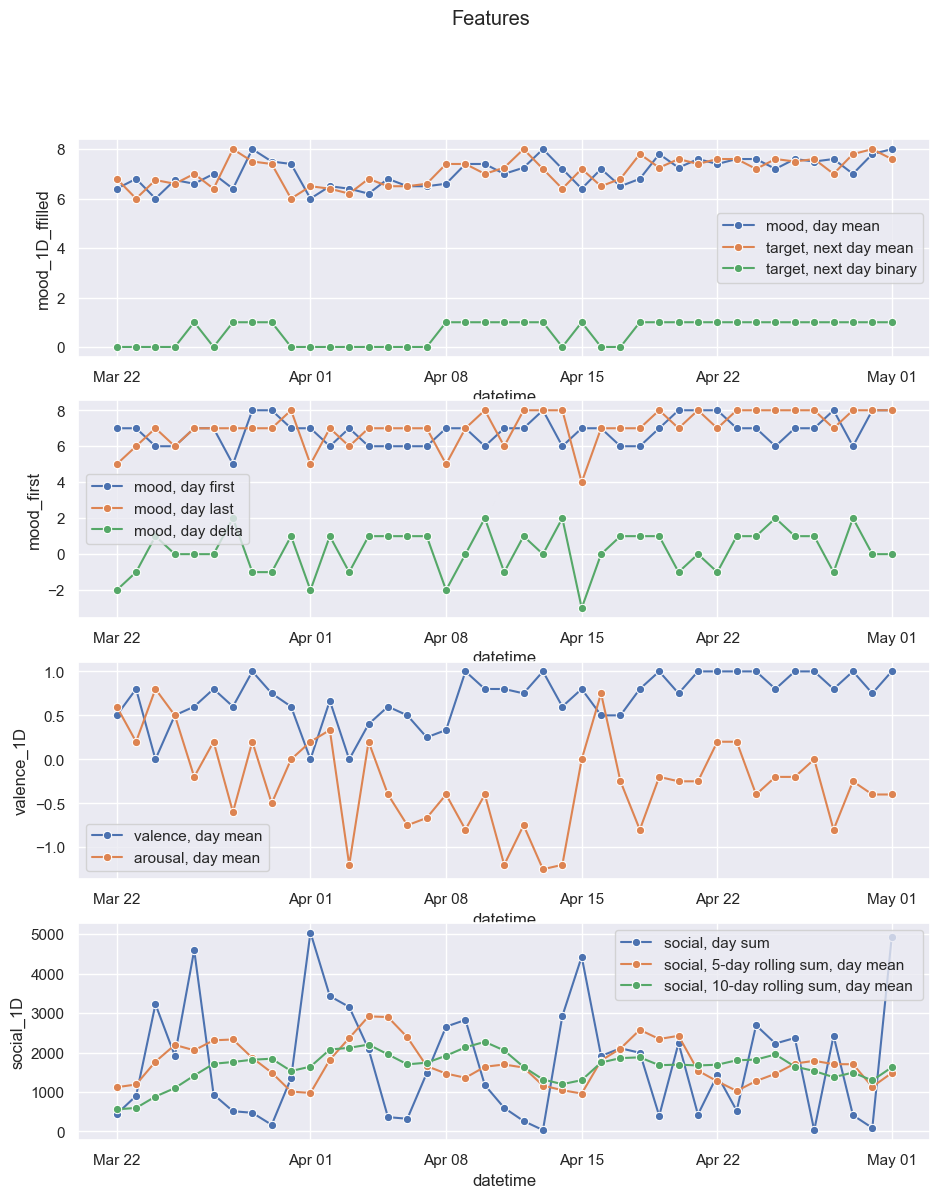

In [10]:
id = 'AS14.01'
start, end = '2014-03-22', '2014-05-01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D_ffilled'].loc[start:end], label='mood, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'].loc[start:end], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'].loc[start:end], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'].loc[start:end], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'].loc[start:end], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'].loc[start:end], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'].loc[start:end], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'].loc[start:end], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'].loc[start:end], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'].loc[start:end], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'].loc[start:end], marker='o', label='social, 10-day rolling sum, day mean ');


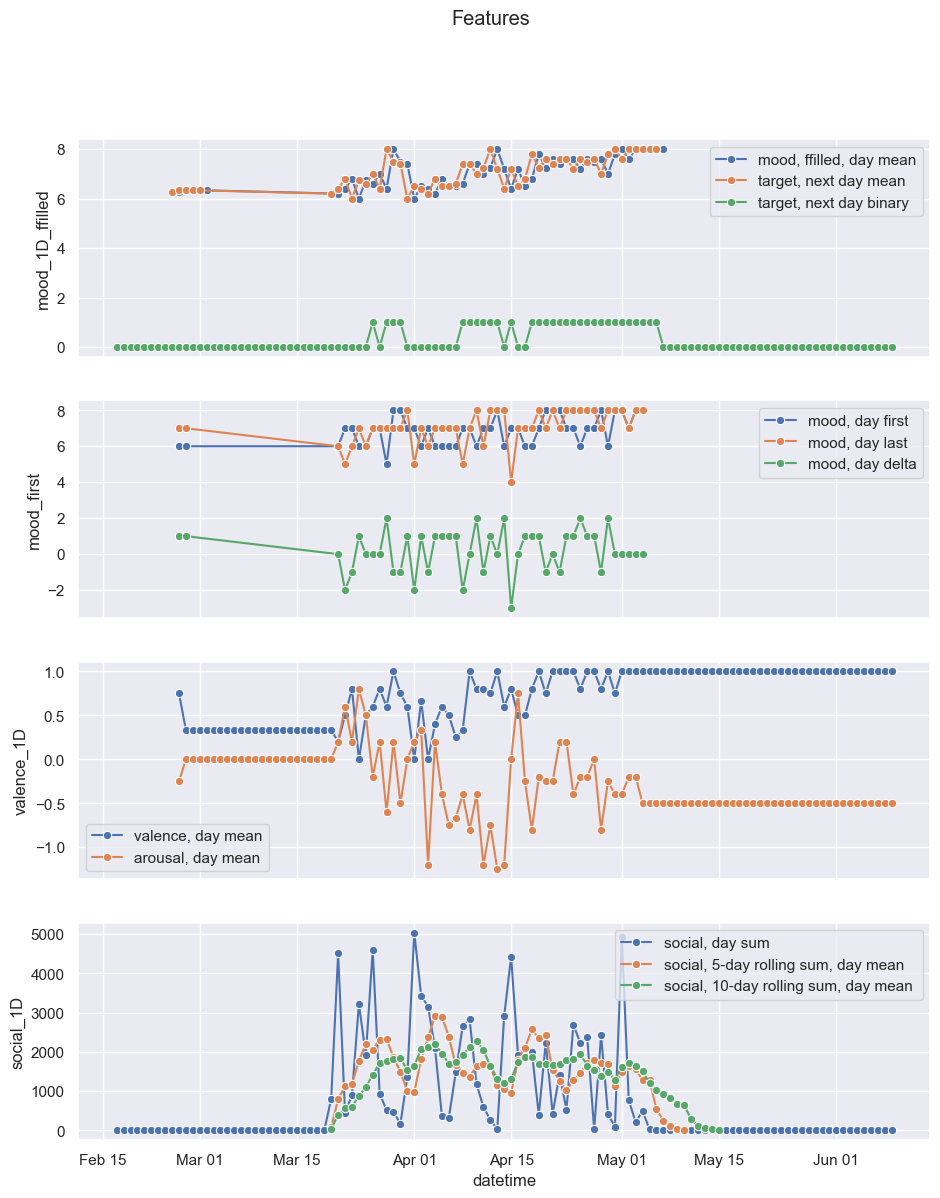

In [11]:
id = 'AS14.01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D_ffilled'], label='mood, ffilled, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'], marker='o', label='social, 10-day rolling sum, day mean ');


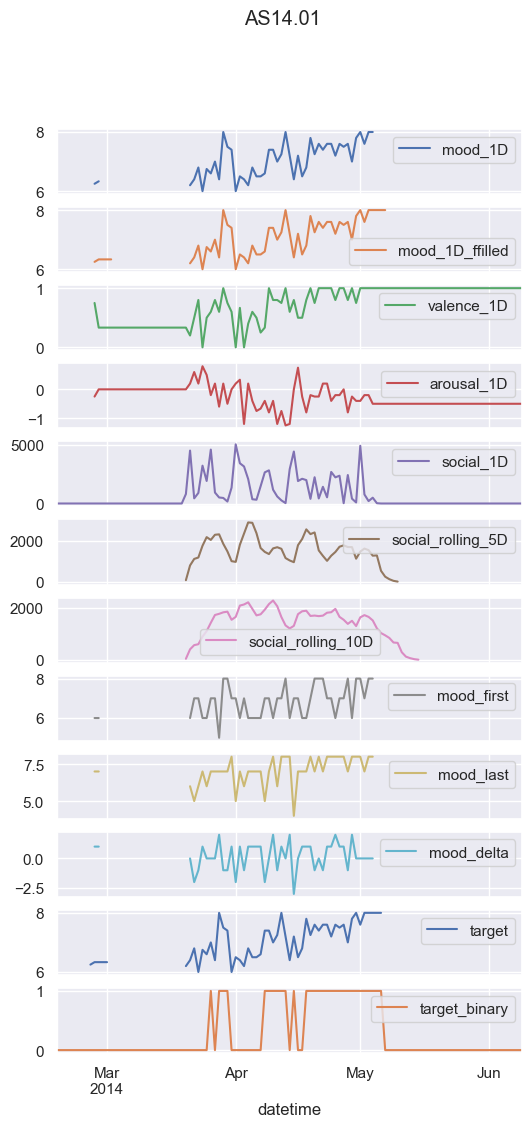

In [12]:
data.plot(subplots=True, figsize=(6, 12), title=id);

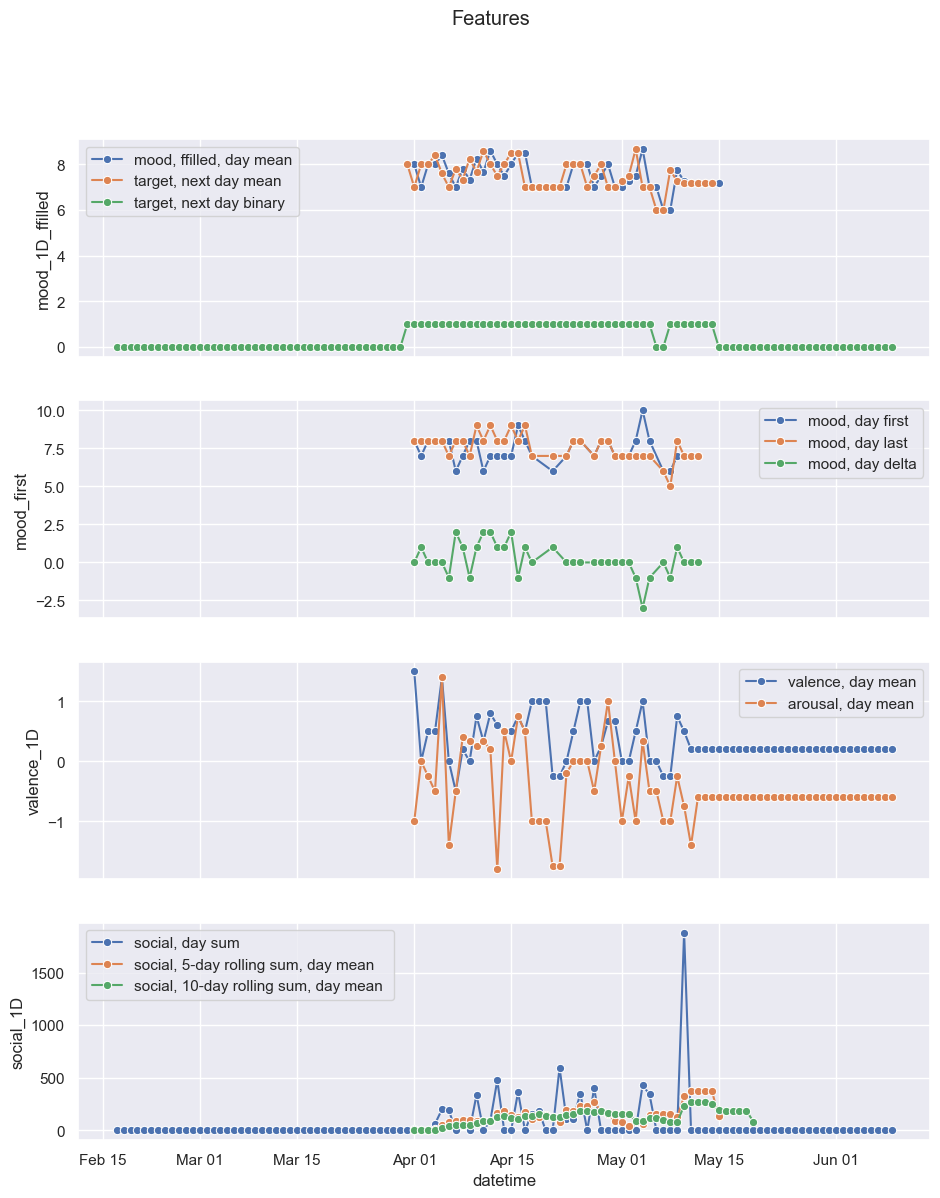

In [13]:
id = 'AS14.32'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')


sns.lineplot(ax=axs[0], data=data['mood_1D_ffilled'], label='mood, ffilled, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'], marker='o', label='social, 10-day rolling sum, day mean ');


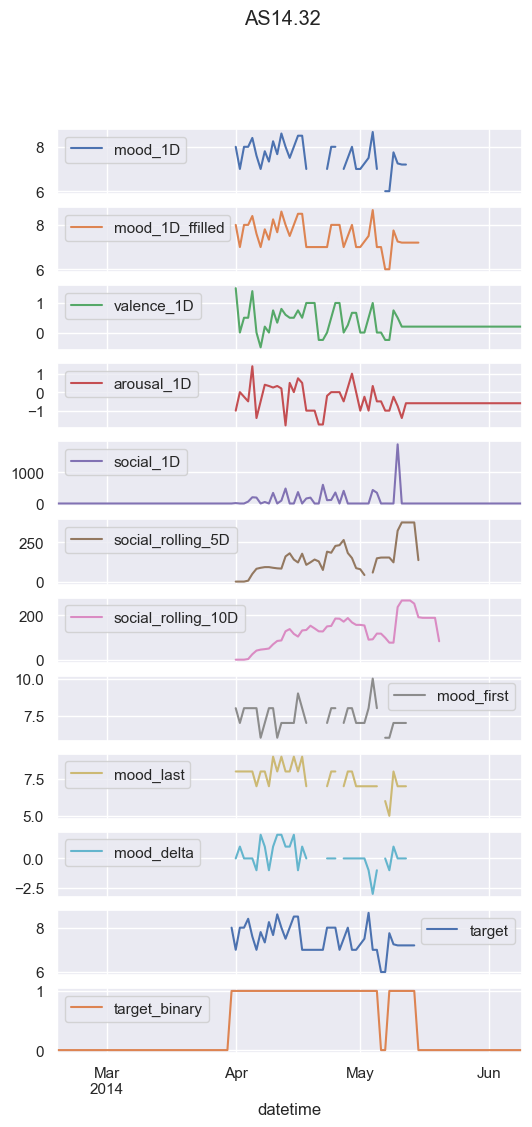

In [14]:
data.plot(subplots=True, figsize=(6, 12), title=id);

## Train and evaluate

In [15]:
def longest_continuous_stretch(x):
    # pad with np.nan
    x = np.append(np.nan, np.append(x, np.nan))
    # find where null
    w = np.where(np.isnan(x))[0]
    # diff to find length of stretch
    # argmax to find where largest stretch
    a = np.diff(w).argmax()
    # return original positions of boundary nulls
    return w[[a, a + 1]] + np.array([0, -2])

In [42]:
all_results = pd.DataFrame(columns=['algo', 'id', 'mean', 'std', 'features'])
all_results

,algo,id,mean,std,features


## Toy decision tree binary classifier, using only previous day mean mood

ID: AS14.01
ID: AS14.02
ID: AS14.03
ID: AS14.05
ID: AS14.06
ID: AS14.07
ID: AS14.08
ID: AS14.09
ID: AS14.12
ID: AS14.13
ID: AS14.14
ID: AS14.15


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ID: AS14.16
ID: AS14.17
ID: AS14.19
ID: AS14.20
ID: AS14.23
ID: AS14.24
ID: AS14.25
ID: AS14.26
ID: AS14.27
ID: AS14.28


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


ID: AS14.29
ID: AS14.30
ID: AS14.31
ID: AS14.32
ID: AS14.33


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


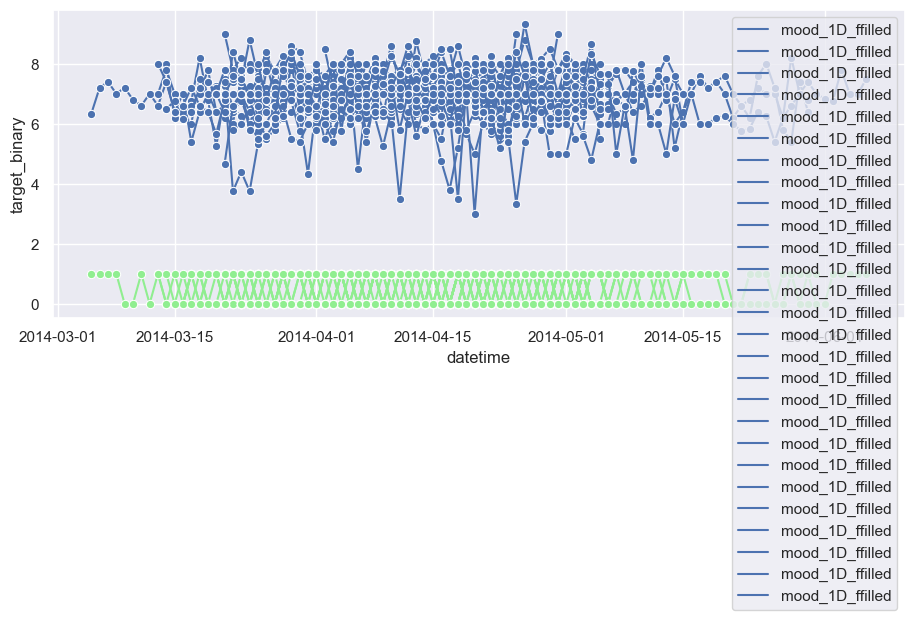

In [43]:
algo = 'decision_tree'
selected_features = ['mood_1D_ffilled']

to_store = []
for id in ids:
#     print(f"############################################################################################")
    print(f"ID: {id}")

    [start, end] = longest_continuous_stretch(features[id]['mood_1D_ffilled'])     
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]
    
    # align y target to resulting x series
    y = features[id]['target_binary']
    # y = features[id]['target']
    y = y.reindex_like(x)

    sns.lineplot(x, marker='o')
    sns.lineplot(y, marker='o', color='lightgreen')

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Decision tree
    clf = DecisionTreeClassifier()
    scores = cross_val_score(clf, x, y, cv=5)
        
#     print(f"Cross validation scores for {id}:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})

results = pd.DataFrame(to_store)


In [44]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.755556,0.083148,[mood_1D_ffilled]
1,decision_tree,AS14.02,0.466667,0.103414,[mood_1D_ffilled]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D_ffilled]
3,decision_tree,AS14.05,0.616364,0.165684,[mood_1D_ffilled]
4,decision_tree,AS14.06,0.735556,0.135974,[mood_1D_ffilled]
5,decision_tree,AS14.07,0.746667,0.154983,[mood_1D_ffilled]
6,decision_tree,AS14.08,0.389744,0.073581,[mood_1D_ffilled]
7,decision_tree,AS14.09,0.415556,0.090976,[mood_1D_ffilled]
8,decision_tree,AS14.12,0.900000,0.093541,[mood_1D_ffilled]
9,decision_tree,AS14.13,0.678182,0.051297,[mood_1D_ffilled]


## All ids: Random Forest classifier, using only previous day mean mood

ID: AS14.01
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.02
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.03


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.05


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.06
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.07
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.08
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.09
Parameters: {'max_depth': 3, 'n_estimators': 100}
ID: AS14.12


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.13


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 4, 'n_estimators': 100}
ID: AS14.14
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.15
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.16
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.17


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.19


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 4, 'n_estimators': 100}
ID: AS14.20
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.23
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.24
Parameters: {'max_depth': 2, 'n_estimators': 100}
ID: AS14.25
Parameters: {'max_depth': 4, 'n_estimators': 50}
ID: AS14.26
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.27
Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.28
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.29
Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.30


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.31


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 50}
ID: AS14.32


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
ID: AS14.33


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 50}


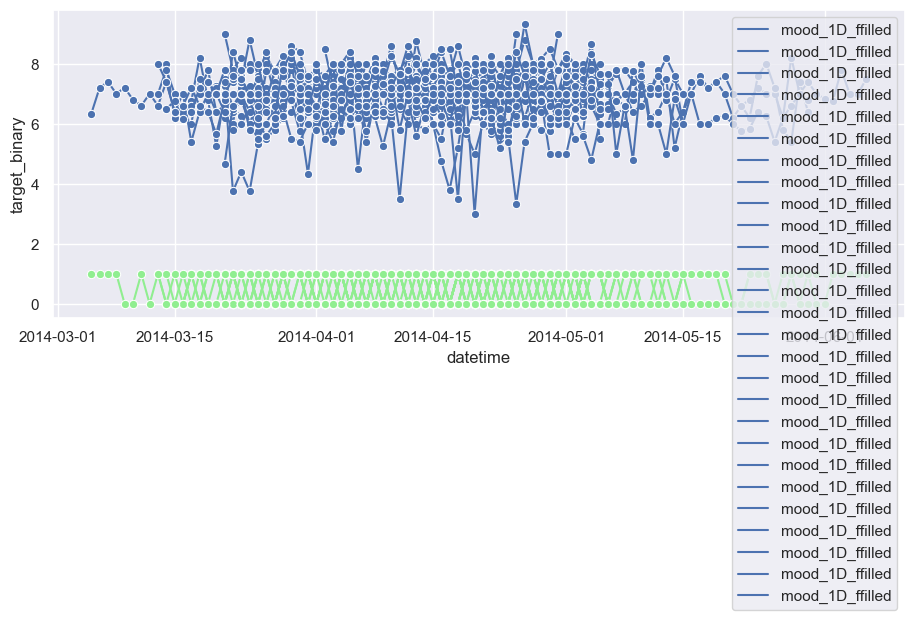

In [45]:
algo = 'random_forest_1'
selected_features = ['mood_1D_ffilled']

to_store = []
for id in ids:
#     print(f"############################################################################################")
    print(f"ID: {id}")

    [start, end] = longest_continuous_stretch(features[id]['mood_1D_ffilled']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]

    # align y target to resulting x series
    y = features[id]['target_binary']
    # y = features[id]['target']
    y = y.reindex_like(x)

    sns.lineplot(x, marker='o')
    sns.lineplot(y, marker='o', color='lightgreen')

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Grid search parameters
    params_to_test = {
#         'n_estimators':[50,100,150,200,250],
        'n_estimators':[50,100],
        'max_depth':[2, 3, 4]
    }

    # Random Forest classifier grid search to find best parameters
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid=params_to_test, cv=5, scoring='accuracy', n_jobs=4)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_ 
    print(f"Parameters: {best_params}")

    # Train and cross validate using best parameters obtained from grid search
    clf = RandomForestClassifier(random_state=42, **best_params)
    scores = cross_val_score(clf, x, y, cv=5)
#     print(f"Cross validation scores:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})

results = pd.DataFrame(to_store)


In [46]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.755556,0.083148,[mood_1D_ffilled]
1,decision_tree,AS14.02,0.466667,0.103414,[mood_1D_ffilled]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D_ffilled]
3,decision_tree,AS14.05,0.616364,0.165684,[mood_1D_ffilled]
4,decision_tree,AS14.06,0.735556,0.135974,[mood_1D_ffilled]
5,decision_tree,AS14.07,0.746667,0.154983,[mood_1D_ffilled]
6,decision_tree,AS14.08,0.389744,0.073581,[mood_1D_ffilled]
7,decision_tree,AS14.09,0.415556,0.090976,[mood_1D_ffilled]
8,decision_tree,AS14.12,0.900000,0.093541,[mood_1D_ffilled]
9,decision_tree,AS14.13,0.678182,0.051297,[mood_1D_ffilled]


## All ids: Random Forest classifier, only using previous day mean mood, valence, arousal

In [21]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.755556,0.083148,[mood_1D_ffilled]
1,decision_tree,AS14.02,0.466667,0.103414,[mood_1D_ffilled]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D_ffilled]
3,decision_tree,AS14.05,0.616364,0.165684,[mood_1D_ffilled]
4,decision_tree,AS14.06,0.735556,0.135974,[mood_1D_ffilled]
...,...,...,...,...,...
22,random_forest_1,AS14.29,0.888889,0.070273,[mood_1D_ffilled]
23,random_forest_1,AS14.30,0.980000,0.040000,[mood_1D_ffilled]
24,random_forest_1,AS14.31,0.727778,0.050918,[mood_1D_ffilled]
25,random_forest_1,AS14.32,0.930556,0.056928,[mood_1D_ffilled]


ID: AS14.01
Parameters: {'max_depth': 4, 'n_estimators': 100}
Cross validation scores:
[0.66666667 0.88888889 1.         0.88888889 0.88888889]
0.87 accuracy with a standard deviation of 0.11

ID: AS14.02
Parameters: {'max_depth': 3, 'n_estimators': 100}
Cross validation scores:
[0.33333333 0.875      0.75       0.5        0.5       ]
0.59 accuracy with a standard deviation of 0.19

ID: AS14.03


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[1.  1.  0.9 1.  1. ]
0.98 accuracy with a standard deviation of 0.04

ID: AS14.05


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[0.63636364 0.90909091 0.81818182 0.5        0.7       ]
0.71 accuracy with a standard deviation of 0.14

ID: AS14.06
Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[0.7        0.77777778 0.77777778 0.66666667 0.55555556]
0.70 accuracy with a standard deviation of 0.08

ID: AS14.07
Parameters: {'max_depth': 3, 'n_estimators': 50}
Cross validation scores:
[0.8        0.8        0.9        0.88888889 0.88888889]
0.86 accuracy with a standard deviation of 0.05

ID: AS14.08
Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[0.46153846 0.61538462 0.66666667 0.58333333 0.5       ]
0.57 accuracy with a standard deviation of 0.08

ID: AS14.09
Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.4        0.44444444 0.77777778 0.55555556 0.77777778]
0.59 accuracy with a standard deviation of 0.16

ID: AS14.12


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[1.    1.    1.    0.875 0.875]
0.95 accuracy with a standard deviation of 0.06

ID: AS14.13


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.54545455 0.81818182 0.54545455 0.8        0.7       ]
0.68 accuracy with a standard deviation of 0.12

ID: AS14.14
Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.6        0.7        0.55555556 0.88888889 0.66666667]
0.68 accuracy with a standard deviation of 0.11

ID: AS14.15
Parameters: {'max_depth': 3, 'n_estimators': 100}
Cross validation scores:
[0.66666667 0.72727273 0.81818182 0.63636364 0.72727273]
0.72 accuracy with a standard deviation of 0.06

ID: AS14.16
Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.45454545 0.63636364 0.72727273 0.63636364 0.5       ]
0.59 accuracy with a standard deviation of 0.10

ID: AS14.17


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[0.9        1.         0.88888889 0.88888889 0.88888889]
0.91 accuracy with a standard deviation of 0.04

ID: AS14.19


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 4, 'n_estimators': 50}
Cross validation scores:
[0.4        0.55555556 0.55555556 0.55555556 0.77777778]
0.57 accuracy with a standard deviation of 0.12

ID: AS14.20
Parameters: {'max_depth': 4, 'n_estimators': 50}
Cross validation scores:
[0.7        0.6        0.66666667 0.66666667 0.66666667]
0.66 accuracy with a standard deviation of 0.03

ID: AS14.23
Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.875 1.    0.875 0.875 0.875]
0.90 accuracy with a standard deviation of 0.05

ID: AS14.24
Parameters: {'max_depth': 2, 'n_estimators': 100}
Cross validation scores:
[0.72727273 0.54545455 0.72727273 0.54545455 0.7       ]
0.65 accuracy with a standard deviation of 0.09

ID: AS14.25
Parameters: {'max_depth': 4, 'n_estimators': 50}
Cross validation scores:
[0.42857143 1.         0.66666667 1.         0.66666667]
0.75 accuracy with a standard deviation of 0.22

ID: AS14.26
Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validati

/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[1.  0.9 1.  1.  1. ]
0.98 accuracy with a standard deviation of 0.04

ID: AS14.31


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 100}
Cross validation scores:
[0.66666667 0.77777778 0.77777778 0.77777778 0.75      ]
0.75 accuracy with a standard deviation of 0.04

ID: AS14.32


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 2, 'n_estimators': 50}
Cross validation scores:
[0.88888889 0.88888889 1.         1.         0.875     ]
0.93 accuracy with a standard deviation of 0.06

ID: AS14.33


/Users/adele/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Parameters: {'max_depth': 3, 'n_estimators': 50}
Cross validation scores:
[0.7        0.66666667 0.77777778 0.66666667 0.66666667]
0.70 accuracy with a standard deviation of 0.04



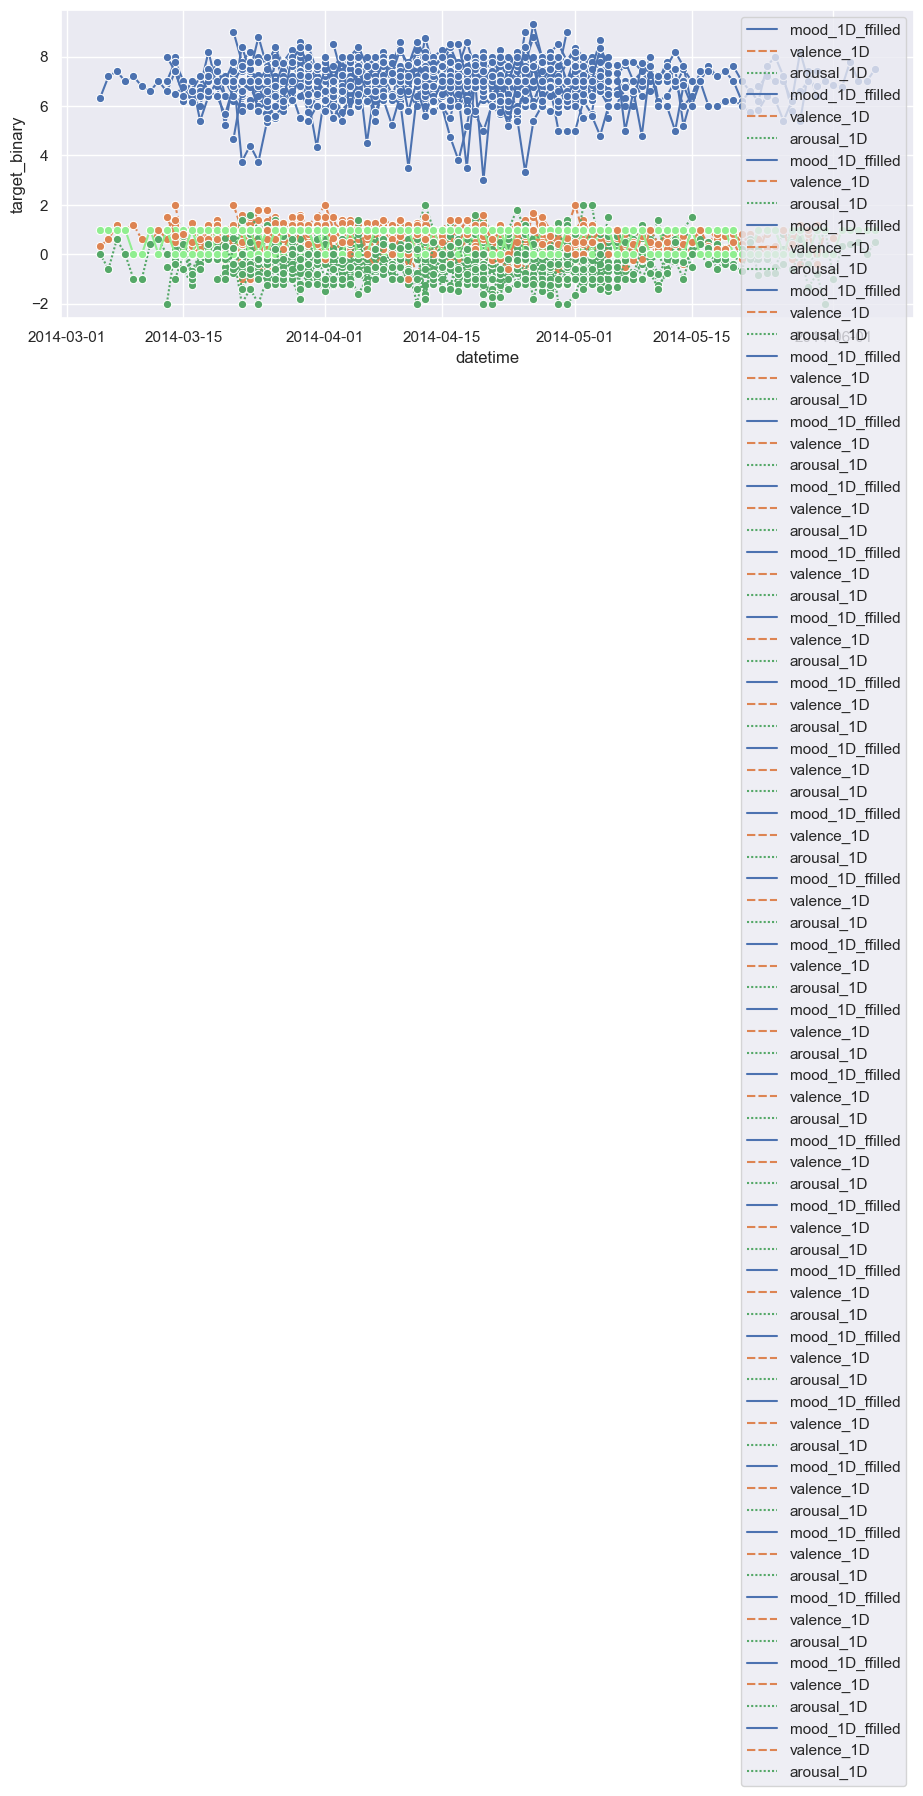

In [47]:
algo = 'random_forest_2'
selected_features = ['mood_1D_ffilled', 'valence_1D', 'arousal_1D']

to_store = []
for id in ids:
#     print(f"############################################################################################")
    print(f"ID: {id}")

    [start, end] = longest_continuous_stretch(features[id]['mood_1D_ffilled']) 
    x = features.iloc[start:end-longest_allowed_gap+1][id][selected_features]

    # align y target to resulting x series
    y = features[id]['target_binary']
    # y = features[id]['target']
    y = y.reindex_like(x)

    sns.lineplot(x, marker='o')
    sns.lineplot(y, marker='o', color='lightgreen')

    # Preprocess labels
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    # Grid search parameters
    params_to_test = {
#         'n_estimators':[50,100,150,200,250],
        'n_estimators':[50,100],
        'max_depth':[2, 3, 4]
    }

    # Random Forest classifier grid search to find best parameters
    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid=params_to_test, cv=5, scoring='accuracy', n_jobs=4)
    grid_search.fit(x, y)
    best_params = grid_search.best_params_ 
    print(f"Parameters: {best_params}")

    # Train and cross validate using best parameters obtained from grid search
    clf = RandomForestClassifier(random_state=42, **best_params)
    scores = cross_val_score(clf, x, y, cv=5)
#     print(f"Cross validation scores:")
#     print(f"{scores}")
#     print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}\n")
    
    to_store.append({'algo': algo, 'id': id, 'mean': scores.mean(), 'std': scores.std(), 'features': selected_features})

results = pd.DataFrame(to_store)


In [50]:
all_results = pd.concat([all_results, results])
all_results

,algo,id,mean,std,features
0,decision_tree,AS14.01,0.755556,0.083148,[mood_1D_ffilled]
1,decision_tree,AS14.02,0.466667,0.103414,[mood_1D_ffilled]
2,decision_tree,AS14.03,0.980000,0.040000,[mood_1D_ffilled]
3,decision_tree,AS14.05,0.616364,0.165684,[mood_1D_ffilled]
4,decision_tree,AS14.06,0.735556,0.135974,[mood_1D_ffilled]
...,...,...,...,...,...
22,random_forest_2,AS14.29,0.886111,0.005556,"[mood_1D_ffilled, valence_1D, arousal_1D]"
23,random_forest_2,AS14.30,0.980000,0.040000,"[mood_1D_ffilled, valence_1D, arousal_1D]"
24,random_forest_2,AS14.31,0.750000,0.043033,"[mood_1D_ffilled, valence_1D, arousal_1D]"
25,random_forest_2,AS14.32,0.930556,0.056928,"[mood_1D_ffilled, valence_1D, arousal_1D]"


## Mean accuracy over all patients

In [57]:
for algo in all_results['algo'].unique():
    print(f"{algo}: {all_results[all_results['algo'] == algo].mean(numeric_only=True)}")

decision_tree: mean    0.691619
std     0.098163
dtype: float64
random_forest_1: mean    0.732569
std     0.096361
dtype: float64
random_forest_2: mean    0.749135
std     0.086195
dtype: float64


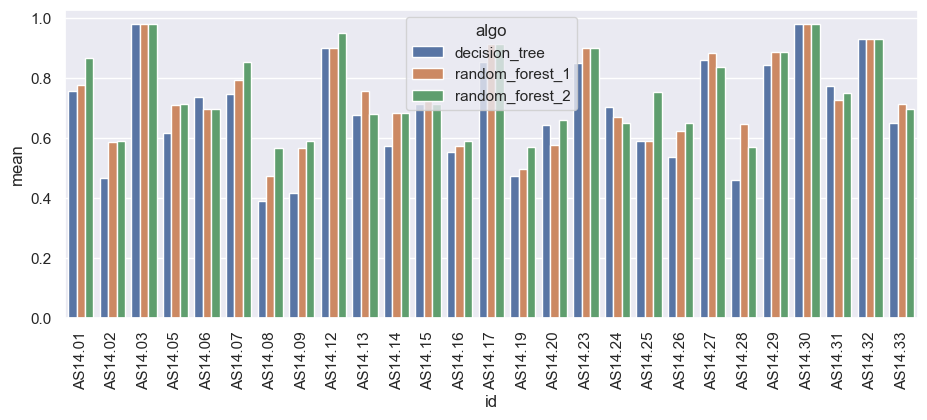

In [73]:
fig, ax = plt.subplots()
sns.barplot(data=all_results, x="id", y="mean", hue="algo")
plt.xticks(rotation=90);